In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.sparse import csr_matrix
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Thu thập và Khám phá Dữ liệu


In [2]:
# Load dữ liệu
movies_df = pd.read_csv('../data/movies.csv')
ratings_df = pd.read_csv('../data/ratings.csv')

print("=" * 60)
print("THÔNG TIN DATASET")
print("=" * 60)
print(f"\nSố lượng phim: {len(movies_df)}")
print(f"Số lượng ratings: {len(ratings_df):,}")
print(f"Số lượng users: {ratings_df['userId'].nunique():,}")
print(f"Số lượng movies được đánh giá: {ratings_df['movieId'].nunique():,}")

print("\n" + "=" * 60)
print("THÔNG TIN MOVIES DATASET")
print("=" * 60)
print(movies_df.head())
print(f"\nShape: {movies_df.shape}")
print(f"\nColumns: {movies_df.columns.tolist()}")
print(f"\nData types:\n{movies_df.dtypes}")
print(f"\nMissing values:\n{movies_df.isnull().sum()}")

print("\n" + "=" * 60)
print("THÔNG TIN RATINGS DATASET")
print("=" * 60)
print(ratings_df.head())
print(f"\nShape: {ratings_df.shape}")
print(f"\nColumns: {ratings_df.columns.tolist()}")
print(f"\nData types:\n{ratings_df.dtypes}")
print(f"\nMissing values:\n{ratings_df.isnull().sum()}")
print(f"\nRating statistics:\n{ratings_df['rating'].describe()}")


THÔNG TIN DATASET

Số lượng phim: 10329
Số lượng ratings: 105,339
Số lượng users: 668
Số lượng movies được đánh giá: 10,325

THÔNG TIN MOVIES DATASET
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Shape: (10329, 3)

Columns: ['movieId', 'title', 'genres']

Data types:
movieId     int64
title      object
genres     object
dtype: object

Missing values:
movieId    0
title      0
genres     0
dtype: int64

THÔNG TIN RATINGS DATASET
   userId  movieId

In [3]:
# Kiểm tra số lượng items (phải ≥ 2,000)
num_items = movies_df['movieId'].nunique()
print(f"Số lượng items (movies): {num_items}")
if num_items >= 2000:
    print("✓ Đạt yêu cầu: Dataset có ≥ 2,000 items")
else:
    print("✗ Không đạt yêu cầu: Dataset cần ≥ 2,000 items")

# Kiểm tra số features mô tả item (phải ≥ 5)
# Từ movies.csv: movieId, title, genres
# Cần tạo thêm features từ genres và title
print(f"\nFeatures hiện có: movieId, title, genres")
print("Sẽ tạo thêm features từ genres (one-hot encoding) và title (năm phát hành)")


Số lượng items (movies): 10329
✓ Đạt yêu cầu: Dataset có ≥ 2,000 items

Features hiện có: movieId, title, genres
Sẽ tạo thêm features từ genres (one-hot encoding) và title (năm phát hành)


In [4]:
# Load dữ liệu poster
movie_poster_df = pd.read_csv('../data/movie_poster.csv', 
                              names=['movieId', 'poster_url'], 
                              header=None)

# Gộp poster vào movies_df
movies_df = movies_df.merge(movie_poster_df, on='movieId', how='left')

print("\n" + "=" * 60)
print("SAU KHI GỘP POSTER")
print("=" * 60)
print(f"Shape: {movies_df.shape}")
print(f"Columns: {movies_df.columns.tolist()}")
print(f"\nSố phim có poster: {movies_df['poster_url'].notna().sum()}")
print(f"Số phim không có poster: {movies_df['poster_url'].isna().sum()}")
print(f"\nSample data với poster:")
print(movies_df[movies_df['poster_url'].notna()].head())
# movies_df.to_csv('../data/movies_with_poster.csv', index=False)
# print("\n✓ Đã lưu file movies_with_poster.csv")


SAU KHI GỘP POSTER
Shape: (10329, 4)
Columns: ['movieId', 'title', 'genres', 'poster_url']

Số phim có poster: 1277
Số phim không có poster: 9052

Sample data với poster:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                          poster_url  
0  https://images-na.ssl-images-amazon.com/images...  
1  https://images-na.ssl-images-amazon.com/images...  
2  https://images-na.ssl-images-amazon.com/images...  
3  htt

In [5]:
# import sys
# import os
# import pandas as pd
# import importlib # <--- Thêm thư viện này

# sys.path.append('../notebook')
# import fetch_posters_tmdb # <--- Import module
# importlib.reload(fetch_posters_tmdb) # <--- [QUAN TRỌNG] Reload module để áp dụng code đa luồng mới cập nhật
# from fetch_posters_tmdb import fetch_missing_posters

# OUTPUT_CSV = "../data/movies_with_posters.csv"
# DELAY = 0.3 
# TEST_LIMIT = 2200 # Mình tăng lên 50 phim để test tốc độ cho đã (xử lý rất nhanh)

# if os.path.exists(OUTPUT_CSV):
#     movies_df_work = pd.read_csv(OUTPUT_CSV)
# else:
#     # Đảm bảo biến movies_df đã được load từ các cell trước
#     movies_df_work = movies_df.copy()
#     if "poster_url" not in movies_df_work.columns:
#         movies_df_work["poster_url"] = None

# to_fetch = movies_df_work[movies_df_work["poster_url"].isna()].head(TEST_LIMIT)

# print(f"\n🚀 FETCH {len(to_fetch)} PHIM")

# # Hàm fetch mới hỗ trợ max_workers để chạy đa luồng
# updated = fetch_missing_posters(
#     to_fetch,
#     delay=DELAY,
#     max_workers=20 # Bạn có thể tăng số luồng này lên (VD: 20) để chạy nhanh hơn nữa
# )

# movies_df_work.loc[updated.index, "poster_url"] = updated["poster_url"]

# movies_df_work.to_csv(
#     OUTPUT_CSV,
#     index=False,
#     encoding="utf-8"
# )

# print("\n✅ FETCH XONG – 5 PHIM ĐẦU:")
# print(updated[["movieId", "title", "poster_url"]].head())

In [6]:
# OUTPUT_CSV = "../data/movies_with_posters.csv"

# df = pd.read_csv(OUTPUT_CSV)

# total = len(df)
# has_poster = df["poster_url"].str.startswith("http", na=False).sum()
# not_found = (df["poster_url"] == "__NOT_FOUND__").sum()
# missing = df["poster_url"].isna().sum()

# print("TOTAL:", total)
# print("HAS_POSTER:", has_poster)
# print("NOT_FOUND:", not_found)
# print("MISSING:", missing)

In [7]:
# import pandas as pd
# import requests
# import time
# import re
# import concurrent.futures
# import os

# # --- Cấu hình ---
# TMDB_API_KEY = "26aca5e9ec14248a120991315b221b91"
# TMDB_BASE_URL = "https://api.themoviedb.org/3"
# INPUT_CSV = "../data/movies_with_posters.csv"
# OUTPUT_CSV = "../data/movies_with_details.csv"
# FETCH_LIMIT = 1000  # Tăng lên 2000 phim mỗi lần vì tốc độ nhanh hơn

# # --- Session Singleton ---
# session = requests.Session()
# adapter = requests.adapters.HTTPAdapter(pool_connections=50, pool_maxsize=50) # Tối ưu connection pool
# session.mount('https://', adapter)

# # --- Hàm hỗ trợ ---
# def extract_title_and_year(title_str):
#     match = re.search(r'^(.+?)\s*\((\d{4})\)', str(title_str))
#     if match: return match.group(1).strip(), match.group(2)
#     return str(title_str).strip(), None

# def fetch_overview_fast(title, year=None):
#     url = f"{TMDB_BASE_URL}/search/movie"
#     params = {"api_key": TMDB_API_KEY, "query": title, "include_adult": False}
#     if year: params["year"] = year
    
#     # Không retry, timeout ngắn (2s) để chạy nhanh
#     try:
#         res = session.get(url, params=params, timeout=2) 
#         if res.status_code == 200:
#             data = res.json()
#             if data.get("results"): return data["results"][0].get("overview", "")
#         # Nếu rate limit (429), chờ xíu
#         elif res.status_code == 429:
#             time.sleep(0.5)
#             return None
#     except: 
#         pass
#     return None

# # --- Main Logic ---
# if os.path.exists(OUTPUT_CSV):
#     df_work = pd.read_csv(OUTPUT_CSV)
# else:
#     df_work = pd.read_csv(INPUT_CSV)
#     if 'overview' not in df_work.columns: df_work['overview'] = ""

# missing_mask = (df_work['overview'].isna()) | (df_work['overview'] == "")
# to_fetch_indices = df_work[missing_mask].head(FETCH_LIMIT).index

# print(f"🚀 Turbo Mode: Fetching {len(to_fetch_indices)} movies with Session Reuse & 40 Threads...")

# def process_idx(idx):
#     row = df_work.loc[idx]
#     title, year = extract_title_and_year(row['title'])
#     overview = fetch_overview_fast(title, year)
#     if not overview and year: 
#         overview = fetch_overview_fast(title, year=None)
#     return idx, overview

# success = 0
# start_time = time.time()

# # Tăng max_workers lên 40
# with concurrent.futures.ThreadPoolExecutor(max_workers=40) as executor:
#     future_map = {executor.submit(process_idx, idx): idx for idx in to_fetch_indices}
    
#     for i, future in enumerate(concurrent.futures.as_completed(future_map)):
#         idx, overview = future.result()
#         if overview:
#             df_work.at[idx, 'overview'] = overview
#             success += 1
        
#         if (i+1) % 200 == 0:
#             elapsed = time.time() - start_time
#             rate = (i+1) / elapsed
#             print(f"[{i+1}/{len(to_fetch_indices)}] Speed: {rate:.1f} reqs/s | Found: {success}", end="\r")

# print(f"\n✅ Done in {time.time()-start_time:.1f}s. Found: {success} descriptions.")

In [8]:
# # Lưu đè vào file output
# df_work.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

# print(f"💾 Đã lưu tiến độ vào: {OUTPUT_CSV}")

# # --- FIX LOGIC ĐẾM ---
# # Coi NaN cũng là thiếu
# missing_count = df_work['overview'].isna().sum() + (df_work['overview'] == "").sum()
# # Hoặc chính xác hơn: đếm số lượng có dữ liệu thực sự
# has_overview_count = df_work['overview'].str.len() > 5  # Giả sử mô tả phải dài hơn 5 ký tự mới tính là có

# print(f"📊 Trạng thái hiện tại:")
# print(f"   - Có overview: {has_overview_count.sum():,} phim")
# print(f"   - Còn thiếu:   {len(df_work) - has_overview_count.sum():,} phim")

# print("\nSample 3 description mới nhất:")
# # Chỉ in những dòng vừa được fetch (có overview)
# fetched_batch = df_work.loc[to_fetch_indices]
# print(fetched_batch[fetched_batch['overview'].str.len() > 0].head(3)[['title', 'overview']])

## 2. Làm sạch và Chuẩn bị Dữ liệu

### 2.1. Xử lý Missing Values


In [9]:
# Kiểm tra missing values
print("Missing values trong movies_df:")
print(movies_df.isnull().sum())
print("\nMissing values trong ratings_df:")
print(ratings_df.isnull().sum())

# Xử lý missing values
# Loại bỏ các dòng có missing values quan trọng
movies_df_clean = movies_df.dropna(subset=['title', 'genres'])
ratings_df_clean = ratings_df.dropna(subset=['userId', 'movieId', 'rating'])

print(f"\nSau khi xử lý missing values:")
print(f"Movies: {len(movies_df)} -> {len(movies_df_clean)}")
print(f"Ratings: {len(ratings_df):,} -> {len(ratings_df_clean):,}")


Missing values trong movies_df:
movieId          0
title            0
genres           0
poster_url    9052
dtype: int64

Missing values trong ratings_df:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Sau khi xử lý missing values:
Movies: 10329 -> 10329
Ratings: 105,339 -> 105,339


### 2.2. Loại bỏ Duplicate


In [10]:
# Kiểm tra duplicates
print("Duplicates trong movies_df:")
print(f"Duplicate rows: {movies_df_clean.duplicated().sum()}")
print(f"Duplicate movieId: {movies_df_clean['movieId'].duplicated().sum()}")

print("\nDuplicates trong ratings_df:")
print(f"Duplicate rows: {ratings_df_clean.duplicated().sum()}")
print(f"Duplicate (userId, movieId) pairs: {ratings_df_clean.duplicated(subset=['userId', 'movieId']).sum()}")

# Loại bỏ duplicates
# Giữ rating cuối cùng nếu user đánh giá cùng một phim nhiều lần
ratings_df_clean = ratings_df_clean.drop_duplicates(subset=['userId', 'movieId'], keep='last')
movies_df_clean = movies_df_clean.drop_duplicates(subset=['movieId'], keep='first')

print(f"\nSau khi loại bỏ duplicates:")
print(f"Movies: {len(movies_df_clean)}")
print(f"Ratings: {len(ratings_df_clean):,}")


Duplicates trong movies_df:
Duplicate rows: 0
Duplicate movieId: 0

Duplicates trong ratings_df:
Duplicate rows: 0
Duplicate (userId, movieId) pairs: 0

Sau khi loại bỏ duplicates:
Movies: 10329
Ratings: 105,339


### 2.3. Tạo Features từ Dữ liệu


In [11]:
# Tạo features từ title (năm phát hành)
import re

def extract_year(title):
    """Trích xuất năm từ title"""
    match = re.search(r'\((\d{4})\)', str(title))
    if match:
        return int(match.group(1))
    return None

movies_df_clean['year'] = movies_df_clean['title'].apply(extract_year)

# Tạo features từ genres (one-hot encoding)
# Tách các genres
all_genres = set()
for genres in movies_df_clean['genres']:
    if pd.notna(genres) and genres != '(no genres listed)':
        all_genres.update(genres.split('|'))

all_genres = sorted(list(all_genres))
print(f"Tổng số genres: {len(all_genres)}")
print(f"Genres: {all_genres}")

# Tạo one-hot encoding cho genres
for genre in all_genres:
    movies_df_clean[f'genre_{genre}'] = movies_df_clean['genres'].apply(
        lambda x: 1 if pd.notna(x) and genre in str(x) else 0
    )

# Tạo thêm features từ ratings (aggregated statistics)
movie_stats = ratings_df_clean.groupby('movieId').agg({
    'rating': ['mean', 'std', 'count']
}).reset_index()
movie_stats.columns = ['movieId', 'avg_rating', 'rating_std', 'rating_count']
movie_stats['rating_std'] = movie_stats['rating_std'].fillna(0)

# Merge với movies_df
movies_df_clean = movies_df_clean.merge(movie_stats, on='movieId', how='left')

print(f"\nSố lượng features sau khi tạo:")
print(f"Genres (one-hot): {len(all_genres)}")
print(f"Features khác: movieId, year, avg_rating, rating_std, rating_count")
print(f"Tổng số features: {len(all_genres) + 5}")

print("\n" + "=" * 60)
print("THÔNG TIN MOVIES SAU KHI TẠO FEATURES")
print("=" * 60)
print(movies_df_clean.head())
print(f"\nShape: {movies_df_clean.shape}")
print(f"\nColumns: {movies_df_clean.columns.tolist()}")


Tổng số genres: 19
Genres: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Số lượng features sau khi tạo:
Genres (one-hot): 19
Features khác: movieId, year, avg_rating, rating_std, rating_count
Tổng số features: 24

THÔNG TIN MOVIES SAU KHI TẠO FEATURES
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                  

### 2.4. Xử lý Outlier


Phân tích outlier trong ratings:
count    105339.000000
mean          3.516850
std           1.044872
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


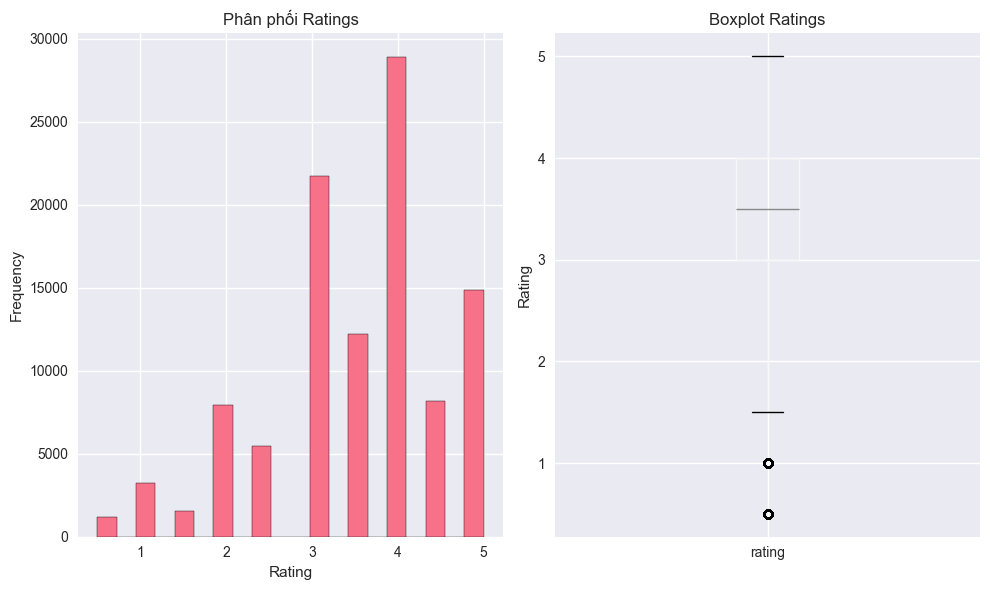


Ratings trước khi xử lý outlier: 105,339
Ratings sau khi xử lý outlier: 105,339

Loại bỏ phim có < 5 ratings
Movies: 10329 -> 3855
Ratings sau khi lọc: 94,121


In [12]:
# Phát hiện và xử lý outlier trong ratings
print("Phân tích outlier trong ratings:")
print(ratings_df_clean['rating'].describe())

# Vẽ boxplot để xem outlier
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
ratings_df_clean['rating'].hist(bins=20, edgecolor='black')
plt.title('Phân phối Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
ratings_df_clean.boxplot(column='rating')
plt.title('Boxplot Ratings')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()

# Xử lý outlier: Ratings ngoài khoảng hợp lý (0.5 - 5.0)
# MovieLens ratings thường từ 0.5 đến 5.0 với bước 0.5
print(f"\nRatings trước khi xử lý outlier: {len(ratings_df_clean):,}")
ratings_df_clean = ratings_df_clean[
    (ratings_df_clean['rating'] >= 0.5) & 
    (ratings_df_clean['rating'] <= 5.0)
]
print(f"Ratings sau khi xử lý outlier: {len(ratings_df_clean):,}")

# Xử lý outlier trong movie statistics
# Loại bỏ các phim có quá ít ratings (có thể là outlier)
min_ratings = 5
print(f"\nLoại bỏ phim có < {min_ratings} ratings")
movies_before = len(movies_df_clean)
movies_df_clean = movies_df_clean[movies_df_clean['rating_count'] >= min_ratings]
print(f"Movies: {movies_before} -> {len(movies_df_clean)}")

# Cập nhật ratings_df để chỉ giữ ratings của các phim còn lại
ratings_df_clean = ratings_df_clean[ratings_df_clean['movieId'].isin(movies_df_clean['movieId'])]
print(f"Ratings sau khi lọc: {len(ratings_df_clean):,}")


### 2.5. Chuẩn hóa Dữ liệu


In [13]:
# Chuẩn hóa các features số
numeric_features = ['year', 'avg_rating', 'rating_std', 'rating_count']
scaler = StandardScaler()

# Lưu bản gốc để so sánh
movies_df_normalized = movies_df_clean.copy()

# Chuẩn hóa
for feature in numeric_features:
    if feature in movies_df_normalized.columns:
        movies_df_normalized[f'{feature}_normalized'] = scaler.fit_transform(
            movies_df_normalized[[feature]]
        )

print("Đã chuẩn hóa các features:")
for feature in numeric_features:
    if f'{feature}_normalized' in movies_df_normalized.columns:
        print(f"  - {feature} -> {feature}_normalized")

# Chuẩn hóa ratings (Min-Max scaling để đưa về [0, 1])
rating_scaler = MinMaxScaler()
ratings_df_clean['rating_normalized'] = rating_scaler.fit_transform(
    ratings_df_clean[['rating']]
)

print(f"\nRatings đã được chuẩn hóa về [0, 1]")
print(f"Rating min: {ratings_df_clean['rating'].min()}, max: {ratings_df_clean['rating'].max()}")
print(f"Rating normalized min: {ratings_df_clean['rating_normalized'].min():.3f}, max: {ratings_df_clean['rating_normalized'].max():.3f}")


Đã chuẩn hóa các features:
  - year -> year_normalized
  - avg_rating -> avg_rating_normalized
  - rating_std -> rating_std_normalized
  - rating_count -> rating_count_normalized

Ratings đã được chuẩn hóa về [0, 1]
Rating min: 0.5, max: 5.0
Rating normalized min: 0.000, max: 1.000


### 2.6. Vector hóa (TF-IDF cho Content-Based)


In [14]:
# Vector hóa genres sử dụng TF-IDF
# Tạo text từ genres cho mỗi phim
movies_df_normalized['genres_text'] = movies_df_normalized['genres'].fillna('')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df_normalized['genres_text'])

print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"Số features TF-IDF: {len(tfidf.get_feature_names_out())}")
print(f"\nMột số features TF-IDF: {tfidf.get_feature_names_out()[:10]}")

# Lưu TF-IDF matrix vào dataframe với movieId làm index
movie_indices = movies_df_normalized['movieId'].values
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=movie_indices,
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
)

print(f"\nTF-IDF DataFrame shape: {tfidf_df.shape}")
print(f"TF-IDF DataFrame head:\n{tfidf_df.head()}")


TF-IDF Matrix shape: (3855, 21)
Số features TF-IDF: 21

Một số features TF-IDF: ['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi']

TF-IDF DataFrame shape: (3855, 21)
TF-IDF DataFrame head:
   tfidf_0   tfidf_1   tfidf_2   tfidf_3   tfidf_4  tfidf_5  tfidf_6  \
1      0.0  0.384668  0.550338  0.499837  0.275036      0.0      0.0   
2      0.0  0.487945  0.000000  0.634036  0.000000      0.0      0.0   
3      0.0  0.000000  0.000000  0.000000  0.589126      0.0      0.0   
4      0.0  0.000000  0.000000  0.000000  0.522230      0.0      0.0   
5      0.0  0.000000  0.000000  0.000000  1.000000      0.0      0.0   

    tfidf_7   tfidf_8  tfidf_9  tfidf_10  tfidf_11  tfidf_12  tfidf_13  \
1  0.000000  0.472945      0.0       0.0       0.0       0.0       0.0   
2  0.000000  0.599924      0.0       0.0       0.0       0.0       0.0   
3  0.000000  0.000000      0.0       0.0       0.0       0.0       0.0   
4  0.462826  0.000000      0.0 

## 3. Xây dựng Hệ Gợi ý Hybrid

### 3.1. Chia Train/Test Split


In [15]:
# Chia train/test split
# Giữ 80% cho training, 20% cho testing
train_df, test_df = train_test_split(
    ratings_df_clean,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train set: {len(train_df):,} ratings ({len(train_df)/len(ratings_df_clean)*100:.1f}%)")
print(f"Test set: {len(test_df):,} ratings ({len(test_df)/len(ratings_df_clean)*100:.1f}%)")

# Tạo user-item matrix cho collaborative filtering
def create_user_item_matrix(df):
    """Tạo user-item matrix từ ratings dataframe"""
    user_item_matrix = df.pivot_table(
        index='userId',
        columns='movieId',
        values='rating',
        fill_value=0
    )
    return user_item_matrix

train_matrix = create_user_item_matrix(train_df)
print(f"\nTrain User-Item Matrix shape: {train_matrix.shape}")
print(f"  - Users: {train_matrix.shape[0]:,}")
print(f"  - Movies: {train_matrix.shape[1]:,}")
print(f"  - Sparsity: {(1 - (train_matrix.values != 0).sum() / train_matrix.size) * 100:.2f}%")


Train set: 75,296 ratings (80.0%)
Test set: 18,825 ratings (20.0%)

Train User-Item Matrix shape: (668, 3854)
  - Users: 668
  - Movies: 3,854
  - Sparsity: 97.08%


### 3.2. Collaborative Filtering (Matrix Factorization với SVD)


In [16]:
# Global mean
global_mean = train_df["rating"].mean()

# User bias
user_bias = (
    train_df.groupby("userId")["rating"].mean() - global_mean
).to_dict()

# Movie bias
movie_bias = (
    train_df.groupby("movieId")["rating"].mean() - global_mean
).to_dict()

In [17]:
# Collaborative Filtering sử dụng SVD (Singular Value Decomposition)
# Chuyển đổi sang sparse matrix để tiết kiệm bộ nhớ
sparse_train_matrix = csr_matrix(train_matrix.values)

# SVD với n_components
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(sparse_train_matrix)
item_factors = svd.components_.T

print(f"SVD Components: {n_components}")
print(f"User factors shape: {user_factors.shape}")
print(f"Item factors shape: {item_factors.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

# Tạo mapping từ movieId sang index
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(train_matrix.columns)}
idx_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_idx.items()}

def predict_rating_cf(user_id, movie_id, user_factors, item_factors, 
                     user_id_to_idx, movie_id_to_idx,
                     global_mean, user_bias, movie_bias):
    # Bias fallback
    bu = user_bias.get(user_id, 0.0)
    bi = movie_bias.get(movie_id, 0.0)
    
    # Nếu user hoặc movie chưa thấy → chỉ dùng bias
    if user_id not in user_id_to_idx or movie_id not in movie_id_to_idx:
        return global_mean + bu + bi
    
    user_idx = user_id_to_idx[user_id]
    movie_idx = movie_id_to_idx[movie_id]
    
    interaction = np.dot(user_factors[user_idx], item_factors[movie_idx])
    
    pred = global_mean + bu + bi + interaction
    return pred  # KHÔNG clip ở đây (giống valuation.ipynb)

# Tạo user_id_to_idx mapping
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(train_matrix.index)}

print("\nĐã xây dựng Collaborative Filtering model!")


SVD Components: 50
User factors shape: (668, 50)
Item factors shape: (3854, 50)
Explained variance ratio: 0.4936

Đã xây dựng Collaborative Filtering model!


### 3.3. Content-Based Filtering


In [18]:
# Content-Based Filtering (tối ưu): KHÔNG tạo full similarity matrix O(n^2)
# Thay vào đó: chỉ tính similarity giữa movie cần dự đoán và các movie user đã rating
# TF-IDF mặc định đã L2-normalize => cosine_similarity ~= dot product

# Mapping movieId -> row index trong TF-IDF
# (tfidf_df được tạo ở bước TF-IDF với index=movieId)
tfidf_movie_id_to_row = {int(mid): i for i, mid in enumerate(tfidf_df.index.values)}

def get_content_similarity(movie_id1, movie_id2, tfidf_matrix, tfidf_movie_id_to_row):
    """Tính similarity giữa 2 phim dựa trên TF-IDF (cosine)."""
    i = tfidf_movie_id_to_row.get(int(movie_id1))
    j = tfidf_movie_id_to_row.get(int(movie_id2))
    if i is None or j is None:
        return 0.0

    # tfidf_matrix là sparse; dot product nhanh hơn gọi cosine_similarity từng cặp
    sim = (tfidf_matrix[i] @ tfidf_matrix[j].T)
    return float(sim.toarray()[0][0])

def predict_rating_cb(user_id, movie_id, train_df, tfidf_matrix, 
                       tfidf_movie_id_to_row,
                       global_mean, user_bias, movie_bias):
    """Dự đoán rating sử dụng Content-Based Filtering (nhanh)."""
    user_ratings = train_df.loc[train_df['userId'] == user_id, ['movieId', 'rating']]
    
    # fallback = mean + bias
    base = (
        global_mean
        + user_bias.get(user_id, 0.0)
        + movie_bias.get(movie_id, 0.0)
    )
    
    if user_ratings.empty:
        return base
    
    target_row = tfidf_movie_id_to_row.get(int(movie_id))
    if target_row is None:
        return base
    
    rated = user_ratings.copy()
    rated['row'] = rated['movieId'].map(tfidf_movie_id_to_row)
    rated = rated.dropna(subset=['row'])
    if rated.empty:
        return base
    
    rated_rows = rated['row'].astype(int).to_numpy()
    ratings = rated['rating'].to_numpy(dtype=float)
    
    sims = (tfidf_matrix[rated_rows] @ tfidf_matrix[target_row].T).toarray().ravel()
    sim_sum = np.abs(sims).sum()
    
    if sim_sum == 0:
        return base
    
    return float((sims * ratings).sum() / sim_sum)

print("\nĐã xây dựng Content-Based Filtering (optimized, on-the-fly)!")



Đã xây dựng Content-Based Filtering (optimized, on-the-fly)!


### 3.4. Hybrid Recommendation System


In [19]:
# Hybrid Recommendation: Kết hợp Collaborative Filtering và Content-Based
# Sử dụng weighted average

def predict_rating_hybrid(user_id, movie_id, 
                         user_factors, item_factors, user_id_to_idx, movie_id_to_idx,
                         train_df, tfidf_matrix, tfidf_movie_id_to_row,
                         global_mean, user_bias, movie_bias,
                         cf_weight=0.3, cb_weight=0.7):
    """
    Dự đoán rating sử dụng Hybrid approach
    
    Parameters:
    - cf_weight: Trọng số cho Collaborative Filtering (default: 0.6)
    - cb_weight: Trọng số cho Content-Based (default: 0.4)
    """
    # Collaborative Filtering prediction
    cf_pred = predict_rating_cf(
        user_id, movie_id,
        user_factors, item_factors,
        user_id_to_idx, movie_id_to_idx,
        global_mean, user_bias, movie_bias
    )
    
    # Content-Based prediction (optimized)
    cb_pred = predict_rating_cb(
        user_id, movie_id,
        train_df, tfidf_matrix, tfidf_movie_id_to_row,
        global_mean, user_bias, movie_bias
    )
    
    # Weighted combination
    hybrid_pred = cf_weight * cf_pred + cb_weight * cb_pred
    
    return hybrid_pred, cf_pred, cb_pred

# Test prediction
sample_user = train_df['userId'].iloc[0]
sample_movie = train_df['movieId'].iloc[0]
actual_rating = train_df[(train_df['userId'] == sample_user) &
                         (train_df['movieId'] == sample_movie)]['rating'].values[0]

hybrid_pred, cf_pred, cb_pred = predict_rating_hybrid(
    sample_user, sample_movie,
    user_factors, item_factors, user_id_to_idx, movie_id_to_idx,
    train_df, tfidf_matrix, tfidf_movie_id_to_row,
    global_mean, user_bias, movie_bias  # Thêm bias parameters
)

print("=" * 60)
print("VÍ DỤ DỰ ĐOÁN")
print("=" * 60)
print(f"User ID: {sample_user}, Movie ID: {sample_movie}")
print(f"Actual Rating: {actual_rating:.2f}")
print(f"CF Prediction: {cf_pred:.2f}")
print(f"CB Prediction: {cb_pred:.2f}")
print(f"Hybrid Prediction: {hybrid_pred:.2f}")
print(f"Error: {abs(actual_rating - hybrid_pred):.2f}")

print("\nĐã xây dựng Hybrid Recommendation System!")


VÍ DỤ DỰ ĐOÁN
User ID: 603, Movie ID: 931
Actual Rating: 5.00
CF Prediction: 5.96
CB Prediction: 3.77
Hybrid Prediction: 4.43
Error: 0.57

Đã xây dựng Hybrid Recommendation System!
